In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from scipy import interp

from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras import optimizers
from keras import initializers

%matplotlib inline 

Using TensorFlow backend.
C:\Users\kt347\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kt347\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kt347\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kt347\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [6]:
df = pd.read_excel("etf_data_final.xlsx")

In [7]:
df.head()

,Unnamed: 0,index,date,SPY_p,IWM_p,EEM_p,TLT_p,LQD_p,TIP_p,IYR_p,...,FXE120_y,SPY250_y,IWM250_y,EEM250_y,TLT250_y,LQD250_y,TIP250_y,IYR250_y,GLD250_y,FXE250_y
0,0,250,2011-12-29,107.496193,66.057526,31.844088,98.016830,85.749313,102.159256,42.352482,...,0,1,0,0,1,1,1,1,1,0
1,1,251,2011-12-30,106.967743,65.701195,31.869280,98.333130,86.112694,102.124252,42.144760,...,0,1,0,0,1,1,1,1,1,0
2,2,252,2012-01-03,108.672401,66.788040,32.843678,96.857132,86.044540,102.089241,42.404408,...,0,1,0,0,1,1,1,1,1,0
3,3,253,2012-01-04,108.842880,66.422791,32.658875,95.705551,86.112694,102.185547,41.929615,...,0,1,0,0,1,1,1,1,1,0
4,4,254,2012-01-05,109.132668,66.796974,32.516071,95.535225,85.741760,102.378059,42.233788,...,0,1,0,0,1,1,1,1,1,0


In [8]:
df.drop(['Unnamed: 0','index','date','month','week'], axis = 1, inplace=True)

In [9]:
df.columns

Index(['SPY_p', 'IWM_p', 'EEM_p', 'TLT_p', 'LQD_p', 'TIP_p', 'IYR_p', 'GLD_p',
       'FXE_p', 'SPY_v',
       ...
       'FXE120_y', 'SPY250_y', 'IWM250_y', 'EEM250_y', 'TLT250_y', 'LQD250_y',
       'TIP250_y', 'IYR250_y', 'GLD250_y', 'FXE250_y'],
      dtype='object', length=287)

In [10]:
p_v_col = ['SPY_p', 'IWM_p', 'EEM_p', 'TLT_p', 
           'LQD_p', 'TIP_p', 'IYR_p', 'GLD_p',
           'FXE_p', 'SPY_v','IWM_v', 'EEM_v',
           'TLT_v', 'LQD_v', 'TIP_v', 'IYR_v',
           'GLD_v', 'FXE_v']

In [11]:
df.drop(p_v_col, axis = 1, inplace=True)

In [12]:
df_col = ['SPY', 'IWM', 'EEM', 'TLT', 'LQD', 'TIP', 'IYR',
       'GLD', 'FXE']

dummy = ['month_1', 
         'month_2', 
         'month_3', 
         'month_4', 
         'month_5', 
         'month_6', 
         'month_7', 
         'month_8', 
         'month_9',
         'month_10',
         'month_11',
         'month_12',
         'MON', 'TUE','WED', 'THU', 'FRI']

td = [1, 3, 5, 10, 20, 40, 60, 120, 250]

In [13]:
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
lw=2

In [14]:
df

,SPY_p_1,SPY_p_3,SPY_p_5,SPY_p_10,SPY_p_20,SPY_p_40,SPY_p_60,SPY_p_120,SPY_p_250,IWM_p_1,...,FXE120_y,SPY250_y,IWM250_y,EEM250_y,TLT250_y,LQD250_y,TIP250_y,IYR250_y,GLD250_y,FXE250_y
0,0.010334,-0.002136,0.015704,0.042549,0.015440,0.040327,0.129784,-0.033292,0.013506,0.010080,...,0,1,0,0,1,1,1,1,1,0
1,-0.004916,-0.007827,0.001836,0.033687,0.010610,0.018598,0.103792,-0.033871,0.009080,-0.005394,...,0,1,0,0,1,1,1,1,1,0
2,0.015936,0.021389,0.008782,0.048606,0.027620,0.016306,0.101456,-0.021750,0.019859,0.016542,...,0,1,0,0,1,1,1,1,1,0
3,0.001569,0.012528,0.009566,0.061601,0.018142,0.024146,0.110620,-0.013406,0.023464,-0.005469,...,0,1,0,0,1,1,1,1,1,0
4,0.002662,0.020239,0.025715,0.033164,0.020529,0.020529,0.077538,-0.016488,0.028207,0.005633,...,0,1,0,0,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022,-0.015117,0.010719,-0.000905,-0.022301,-0.089215,-0.098368,-0.086366,-0.095581,-0.055381,-0.022196,...,0,0,0,0,0,0,0,0,0,0
1023,0.013643,0.018801,0.011379,-0.009942,-0.075263,-0.085936,-0.084317,-0.081447,-0.030055,0.019976,...,0,0,0,0,0,0,0,0,0,0
1024,-0.010883,-0.012545,0.013359,-0.028555,-0.083232,-0.096919,-0.093762,-0.094428,-0.049398,-0.013749,...,0,0,0,0,0,0,0,0,0,0
1025,0.005209,0.007834,0.012963,0.001483,-0.088187,-0.088430,-0.085098,-0.082196,-0.032277,-0.000201,...,0,0,0,0,0,0,0,0,0,0


In [15]:
from sklearn.preprocessing import StandardScaler, RobustScaler

SPY
Processing for horizon =  1
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 1s 1ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 1s 1ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 1s 1ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 1s 1ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 2s 2ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 2s 2ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
AUC good =  0.5
accuracy :  0.5760517799352751


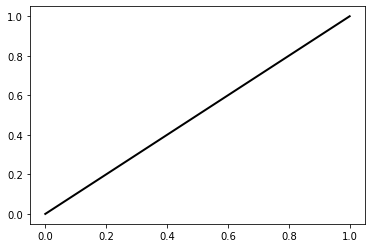

Processing for horizon =  3
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 2s 2ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
AUC good =  0.5
accuracy :  0.6181229773462783


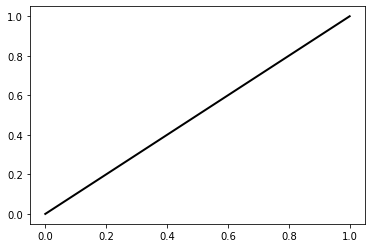

Processing for horizon =  5
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
AUC good =  0.5
accuracy :  0.3948220064724919


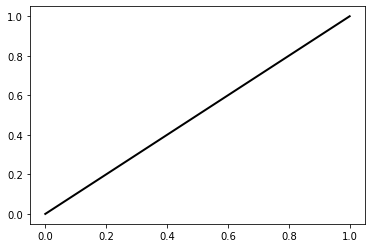

Processing for horizon =  10
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
AUC good =  0.5
accuracy :  0.6375404530744336


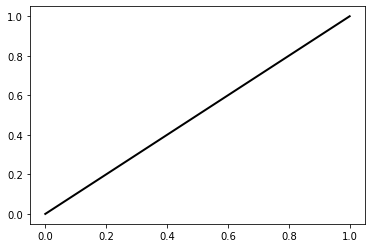

Processing for horizon =  20
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 1s 2ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 2s 2ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 2s 2ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 2s 2ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 2s 2ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 2s 2ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 2s 2ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 2s 2ms/step
AUC good =  0.5126538354770056
accuracy :  0.3656957928802589


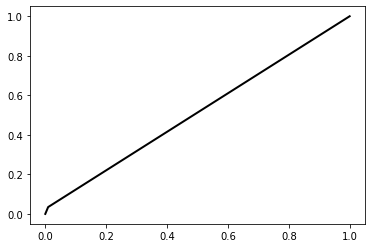

Processing for horizon =  40
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 2s 2ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 2s 2ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 2s 2ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 2s 2ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
AUC good =  0.5
accuracy :  0.7766990291262136


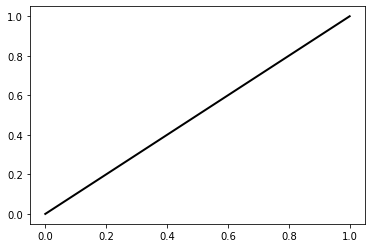

Processing for horizon =  60
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
AUC good =  0.5
accuracy :  0.18770226537216828


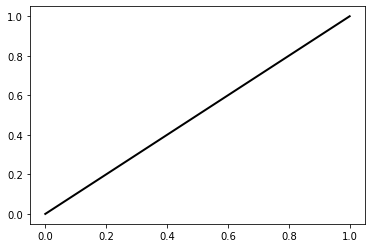

Processing for horizon =  120
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
AUC good =  0.5
accuracy :  0.10355987055016182


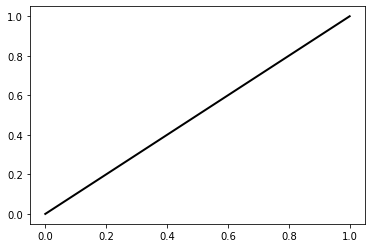

Processing for horizon =  250
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 4s 6ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
AUC good =  0.33952702702702703
accuracy :  0.6504854368932039


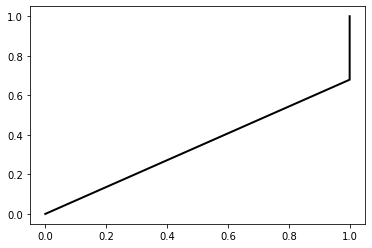

IWM
Processing for horizon =  1
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 4s 6ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 4s 6ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 5s 7ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
AUC good =  0.44798149705634993
accuracy :  0.42718446601941745


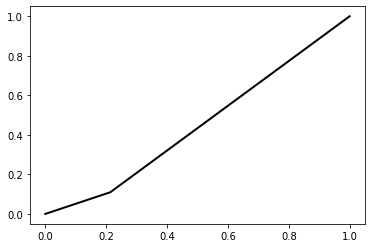

Processing for horizon =  3
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
AUC good =  0.5038448393711552
accuracy :  0.4368932038834951


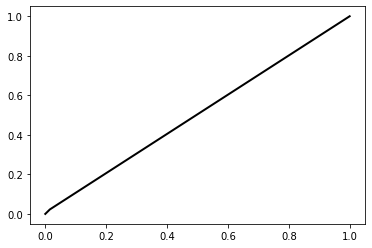

Processing for horizon =  5
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
AUC good =  0.5
accuracy :  0.5566343042071198


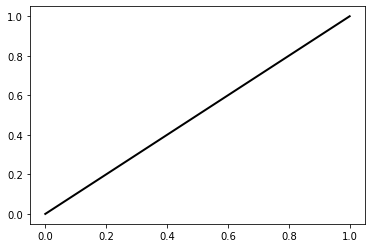

Processing for horizon =  10
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
AUC good =  0.5
accuracy :  0.5501618122977346


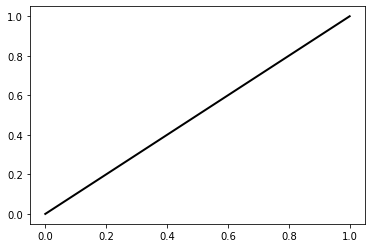

Processing for horizon =  20
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 2s 3ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 3s 3ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
AUC good =  0.5
accuracy :  0.598705501618123


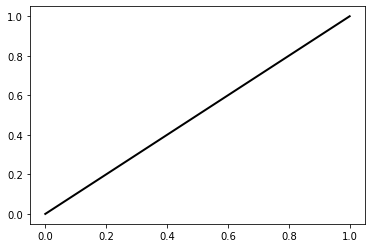

Processing for horizon =  40
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
AUC good =  0.4549731182795699
accuracy :  0.32362459546925565


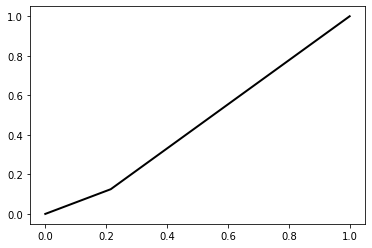

Processing for horizon =  60
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 5s 8ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 5s 7ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 5s 7ms/step
AUC good =  0.5
accuracy :  0.2686084142394822


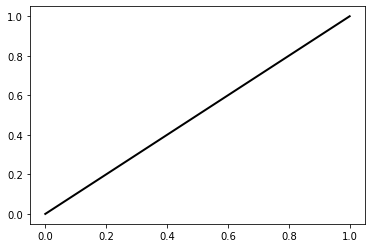

Processing for horizon =  120
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 5s 7ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 5s 7ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 5s 7ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 5s 7ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 5s 7ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
AUC good =  0.5
accuracy :  0.2459546925566343


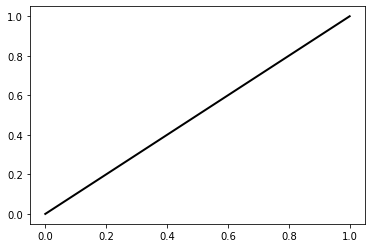

Processing for horizon =  250
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
AUC good =  0.5
accuracy :  0.8737864077669902


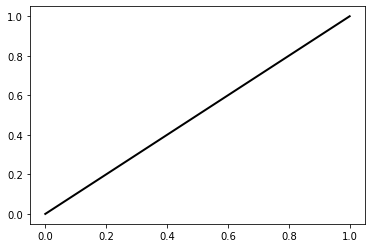

EEM
Processing for horizon =  1
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
AUC good =  0.5466130255286882
accuracy :  0.540453074433657


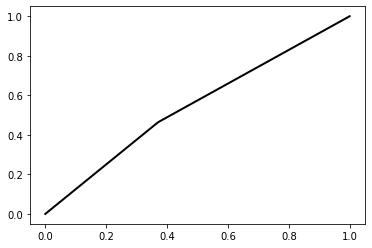

Processing for horizon =  3
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 3s 4ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 3s 5ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 3s 5ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 3s 5ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 3s 5ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 3s 5ms/step
AUC good =  0.5
accuracy :  0.5372168284789643


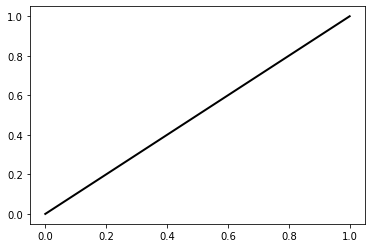

Processing for horizon =  5
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 3s 5ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 3s 5ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 3s 5ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 3s 5ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 3s 5ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 3s 5ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 3s 5ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 3s 5ms/step
AUC good =  0.5
accuracy :  0.511326860841424


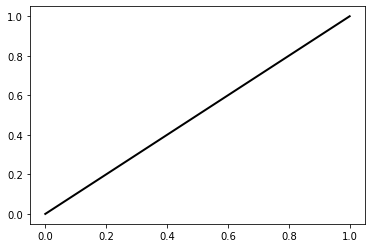

Processing for horizon =  10
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 7s 9ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 7s 9ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 7s 9ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 7s 9ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 7s 9ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 6s 9ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
AUC good =  0.5
accuracy :  0.511326860841424


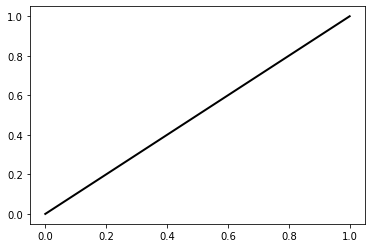

Processing for horizon =  20
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
AUC good =  0.5
accuracy :  0.5469255663430421


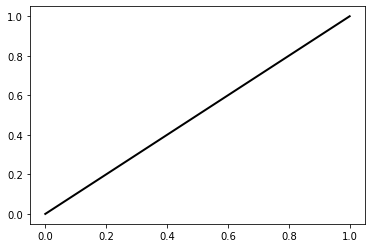

Processing for horizon =  40
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 4s 6ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
AUC good =  0.5
accuracy :  0.5048543689320388


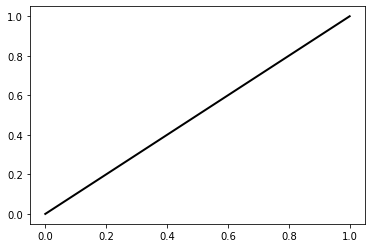

Processing for horizon =  60
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
AUC good =  0.5279290982232652
accuracy :  0.5210355987055016


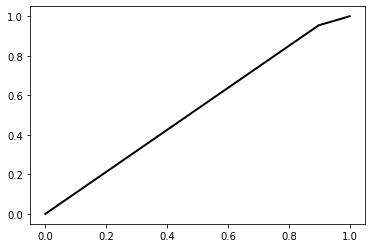

Processing for horizon =  120
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 4s 5ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 4s 6ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 7s 10ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 7s 10ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 7s 10ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 7s 10ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 9s 12ms/step
AUC good =  0.5
accuracy :  0.49514563106796117


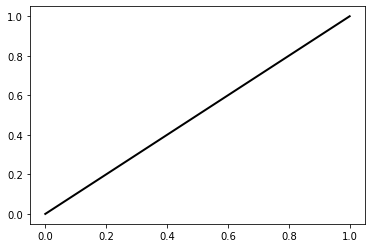

Processing for horizon =  250
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 4s 6ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 4s 6ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 4s 6ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 4s 6ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 5s 7ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 4s 6ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 5s 6ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 5s 7ms/step
AUC good =  0.5007333221589004
accuracy :  0.5080906148867314


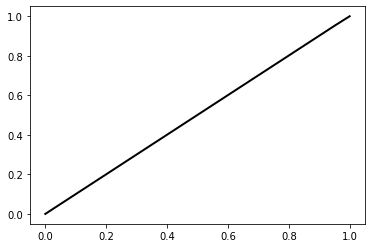

TLT
Processing for horizon =  1
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 4s 6ms/step
Alpha =  1.0
Epoch 1/1
718/718 [==============================] - 4s 6ms/step
Alpha =  100.0
Epoch 1/1
718/718 [==============================] - 4s 6ms/step
Alpha =  1000.0
Epoch 1/1
718/718 [==============================] - 4s 6ms/step
Alpha =  10.0
Epoch 1/1
718/718 [==============================] - 4s 6ms/step
Alpha =  0.01
Epoch 1/1
718/718 [==============================] - 4s 6ms/step
Alpha =  0.0001
Epoch 1/1
718/718 [==============================] - 4s 6ms/step
Alpha =  0.001
Epoch 1/1
718/718 [==============================] - 4s 6ms/step
AUC good =  0.5419463087248322
accuracy :  0.540453074433657


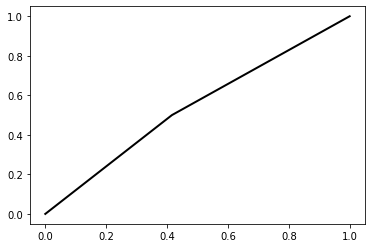

Processing for horizon =  3
Alpha =  0.1
Epoch 1/1
718/718 [==============================] - 5s 6ms/step


In [ ]:
%%time
#df_data = pd.DataFrame
#df_data = df[dummy]

for i in df_col:
    
    print(i)
    
    for j in td:
                
        y_col = str(i)+str(j)+"_y"
                
        y_columns = df.columns[188:]
        
        #df_data[[r_col, v_col, y_col]] = df[[r_col, v_col, y_col]]
        
        X = df.drop(y_columns, axis = 1)
        X = df.drop([y_col], axis = 1)
        StandardScaler().fit_transform(X)
        
        y = df[y_col]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=0.3,
                                                            random_state=0)
        
        
        print("Processing for horizon = ",j)
        
  
        for reg in {0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0}:
            
                        
            # Use 2 hidden layers {100,100}
            print ("Alpha = ", reg)
            model = Sequential()
            model.add(Dense(100, input_dim=268, kernel_initializer='uniform',
                            kernel_regularizer=regularizers.l2(reg),
                            activation='relu'))
            
            
            model.add(Dense(100, kernel_initializer='uniform', activation='relu'))
            
            
            model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
            
            
            sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=1.)
            
            
            model.compile(loss='mean_squared_error', optimizer=sgd, )
            
            

            model.fit(np.array(X_train), np.array(y_train), epochs=1,batch_size=100)
            
            
            neval = model.evaluate(np.array(X_train), np.array(y_train))
            
            
            preds = model.predict(np.array(X_test))
            
            #print(preds)
            
            probs = model.predict_proba(X_test)
            
            #print(probs)
                        
        fpr, tpr, thresholds = roc_curve(y_test, probs)
        #fpr, tpr, thresholds = roc_curve(y_test, predictions)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        print ("AUC good = ",roc_auc)
        print("accuracy : ", metrics.accuracy_score(y_test, preds))
        plt.plot(fpr, tpr, lw=lw, color='black')
        #plt.title("Horizon = "+str(filename))
        plt.show()